In [1]:
from google.colab import drive

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import argparse

import cv2

import os
from sklearn.utils import shuffle
from tqdm import tqdm

import numpy as np


In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)



train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/dataset',
        target_size=(370, 370),
        batch_size=924,
        shuffle=False
        )



Found 922 images belonging to 2 classes.


In [4]:
X_train, y_train = next(train_generator)
print(len(X_train))
len(y_train)

922


922

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

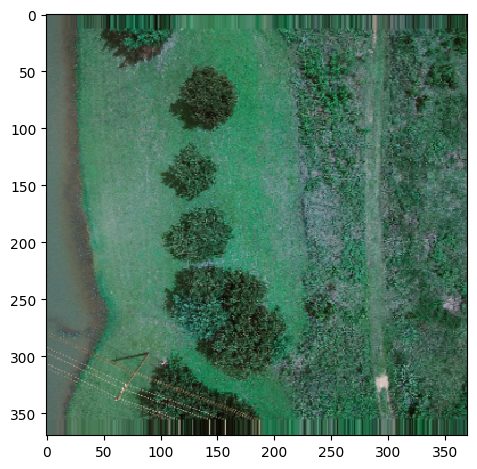

In [5]:

resizedimgs=X_train
label_names=train_generator.labels
resizedimgs, label_names = shuffle(resizedimgs, label_names)
from skimage import io

io.imshow(resizedimgs[0])
# io.imshow(resizedimgs[1])
# io.imshow(resizedimgs[2])
# io.imshow(resizedimgs[3])
# io.imshow(resizedimgs[4])
# io.imshow(resizedimgs[5])
# io.imshow(resizedimgs[6])
# io.imshow(resizedimgs[7])
label_names[0:10]



In [6]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [7]:
def create_features(img):
    # flatten three channel color image
    
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2gray(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack((hog_features))
    return flat_features
bombus_features = create_features(resizedimgs[0])
print(bombus_features)

[0.17881617 0.01599707 0.00480658 ... 0.05670142 0.02496899 0.08232882]


In [8]:
def create_feature_matrix(imgs):
    features_list = []
    
    for img_id in imgs:
        # load image
        
        # get features for image
        image_features = create_features(img_id)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(resizedimgs)
print(feature_matrix.shape)

(922, 35721)


In [9]:
# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = ss.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)

PCA matrix shape is:  (922, 35721)


In [10]:
X = pd.DataFrame(bees_pca)
y = pd.Series(label_names)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=142)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

0    384
1    353
dtype: int64

In [11]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=123)

# fit model
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=123)

In [12]:
from sklearn.metrics import classification_report
print(len(X_test))
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print('Model accuracy is: ', accuracy)
print(classification_report(y_test,y_pred))

185
Model accuracy is:  0.8
              precision    recall  f1-score   support

           0       0.72      0.86      0.78        77
           1       0.88      0.76      0.82       108

    accuracy                           0.80       185
   macro avg       0.80      0.81      0.80       185
weighted avg       0.81      0.80      0.80       185



In [19]:
# Importing all necessary libraries
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

img_width, img_height = 370, 370


In [20]:
if K.image_data_format() == 'channels_first':
    	input_shape = (3, img_width, img_height)
else:
	input_shape = (img_width, img_height, 3)


In [21]:
model=Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [22]:
model.compile(loss='binary_crossentropy',
			optimizer='rmsprop',
			metrics=['accuracy'])


In [23]:
X_train=resizedimgs.reshape(resizedimgs.shape[0],370,370,3)
y_train = np.asarray(label_names).astype('float32').reshape((-1,1))
# X_test=X_test.reshape(X_test.shape[0],28,28,1)

In [24]:
model.fit(X_train, label_names, batch_size=32, epochs=10)

Epoch 1/10
29/29 [==============================] - 15s 463ms/step - loss: 12.6655 - accuracy: 0.5564
Epoch 2/10
29/29 [==============================] - 13s 452ms/step - loss: 0.5998 - accuracy: 0.6627
Epoch 3/10
29/29 [==============================] - 13s 459ms/step - loss: 0.6294 - accuracy: 0.6692
Epoch 4/10
29/29 [==============================] - 13s 462ms/step - loss: 0.7705 - accuracy: 0.6931
Epoch 5/10
29/29 [==============================] - 14s 480ms/step - loss: 0.7684 - accuracy: 0.6540
Epoch 6/10
29/29 [==============================] - 14s 479ms/step - loss: 0.5026 - accuracy: 0.7777
Epoch 7/10
29/29 [==============================] - 14s 476ms/step - loss: 0.4414 - accuracy: 0.7907
Epoch 8/10
29/29 [==============================] - 14s 474ms/step - loss: 0.5072 - accuracy: 0.7852
Epoch 9/10
29/29 [==============================] - 14s 475ms/step - loss: 0.3934 - accuracy: 0.8200
Epoch 10/10
29/29 [==============================] - 14s 472ms/step - loss: 0.4137 - accur